In [1465]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

In [1466]:
warnings.filterwarnings("ignore")

In [1467]:
route_segments = pd.read_csv("DATA\\route_segements.csv")  # load 'route_segments' table

In [1468]:
route_segments.info()  # 554 non-null rows (due to the fact that in starting table only items with segment_type equal to true have inserted order_id)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   segment_id          1000 non-null   int64  
 1   driver_id           1000 non-null   int64  
 2   segment_type        1000 non-null   object 
 3   order_id            446 non-null    float64
 4   segment_start_time  1000 non-null   object 
 5   segment_end_time    1000 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 47.0+ KB


In [1469]:
route_segments = route_segments.drop(["segment_id"], axis=1)  # drop unnecessary column

In [1470]:
route_segments['order_id'] = route_segments['order_id'].fillna(method='ffill')  # add order_id to all rows (also to rows in which segment_type is equal to 'DRIVE') based on upper row value

In [1471]:
drive_segments = route_segments[route_segments['segment_type'] == 'DRIVE']  # select rows with segment_type equal to 'DRIVE;

In [1472]:
drive_segments["order_id"] = drive_segments["order_id"].astype('int64')

In [1473]:
drive_segments[["segment_start_time", "segment_end_time"]] = drive_segments[["segment_start_time", "segment_end_time"]].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')  #change to datatime format

In [1474]:
drive_segments['delivery_time_seconds'] = (drive_segments['segment_end_time'] - drive_segments['segment_start_time']).dt.total_seconds() # count actual delivery time (in seconds)

In [1475]:
drive_segments['delivery_time_rounded_minutes'] = drive_segments['delivery_time_seconds'].apply(lambda x: int(np.round(x)/60))  # the actual delivery time with 1 minute granularity

<Figure size 1600x1000 with 0 Axes>

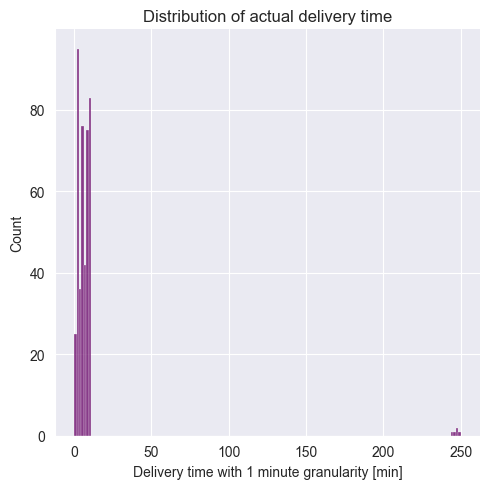

In [1476]:
plt.figure(figsize=(8, 5), dpi=200)
sns.displot(
    data=drive_segments[drive_segments["delivery_time_seconds"]>=0], x="delivery_time_rounded_minutes", color='#660066'
)
plt.title("Distribution of actual delivery time")
plt.xlabel("Delivery time with 1 minute granularity [min]")
plt.tight_layout()
plt.savefig("charts\\distribution_of_actual delivery_time.png");  # histogram for all orders' delivery time

<Figure size 1600x1000 with 0 Axes>

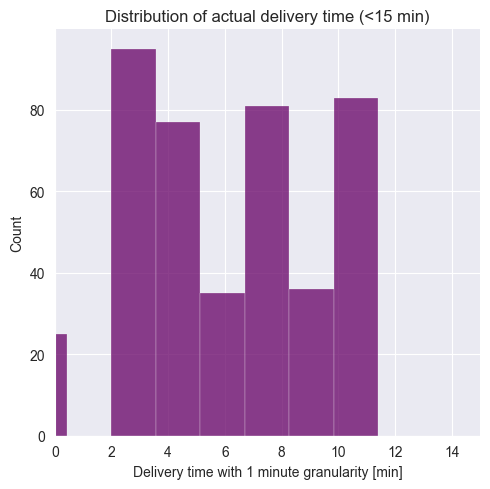

In [1477]:
plt.figure(figsize=(8, 5), dpi=200)
sns.displot(
    data=drive_segments, x="delivery_time_rounded_minutes", color='#660066', 
)
plt.title("Distribution of actual delivery time (<15 min)")
plt.xlabel("Delivery time with 1 minute granularity [min]")
plt.xlim((0,15))
plt.tight_layout()
plt.savefig("charts\\distribution_of_actual delivery_time_left_part.png");  # only left part of the upper histogram is show - only for orders whose delivery time is less than 15 minutes (most of them)

In [1478]:
orders = pd.read_csv("DATA\\orders.csv")

In [1479]:
delivered_orders = pd.merge(drive_segments, orders, on='order_id')  # df which contains all orders that have defined planned delivery duration and actual delivery duration

In [1480]:
delivered_orders["error"] = delivered_orders["planned_delivery_duration"] -delivered_orders["delivery_time_seconds"]  # count prediction error

<Figure size 3400x1000 with 0 Axes>

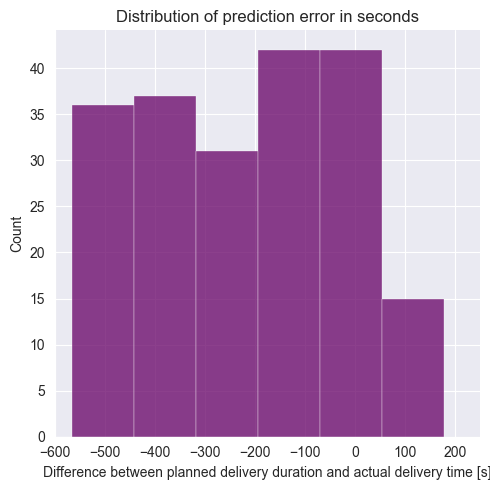

In [1481]:
plt.figure(figsize=(17, 5), dpi=200)
sns.displot(
    data=delivered_orders, x="error", color='#660066'
)
plt.title("Distribution of prediction error in seconds")
plt.xlabel("Difference between planned delivery duration and actual delivery time [s]")
plt.tight_layout()
plt.xlim((-600,250))
plt.savefig("charts\\distribution_of_prediction_error_in_seconds");  # prediction error in seconds displayed

In [1482]:
delivered_orders["error_percentage"] = (np.abs(delivered_orders["error"]) / delivered_orders["delivery_time_seconds"])*100  #count percentage error

<Figure size 3400x1000 with 0 Axes>

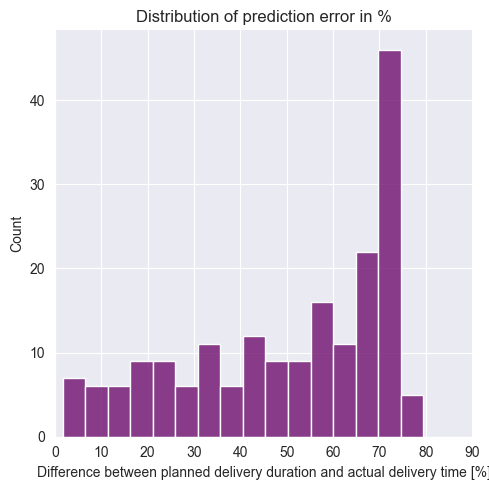

In [1483]:
plt.figure(figsize=(17, 5), dpi=200)
sns.displot(
    data=delivered_orders, x="error_percentage", color='#660066', bins=20
)
plt.title("Distribution of prediction error in %")
plt.xlabel("Difference between planned delivery duration and actual delivery time [%]")
plt.xlim((0,90))
plt.tight_layout()
plt.savefig("charts\\distribution_of_prediction_error_in_percents");  # prediction error in % displayed

In [1484]:
delivered_orders[delivered_orders["error"] < -1000]  # display off cases with huge error

,driver_id,segment_type,order_id,segment_start_time,segment_end_time,delivery_time_seconds,delivery_time_rounded_minutes,customer_id,sector_id,planned_delivery_duration,error,error_percentage
66,1,DRIVE,322,2024-02-20 07:53:22,2024-02-20 12:03:41,15019.0,250,256,2,178,-14841.0,98.814835
178,3,DRIVE,410,2024-02-20 02:33:32,2024-02-20 06:41:19,14867.0,247,260,2,178,-14689.0,98.802717


In [1485]:
actual_sector_delivery_durations = delivered_orders.groupby('sector_id')['delivery_time_seconds'].mean()  # calculate mean planned delivery duration in sectors 

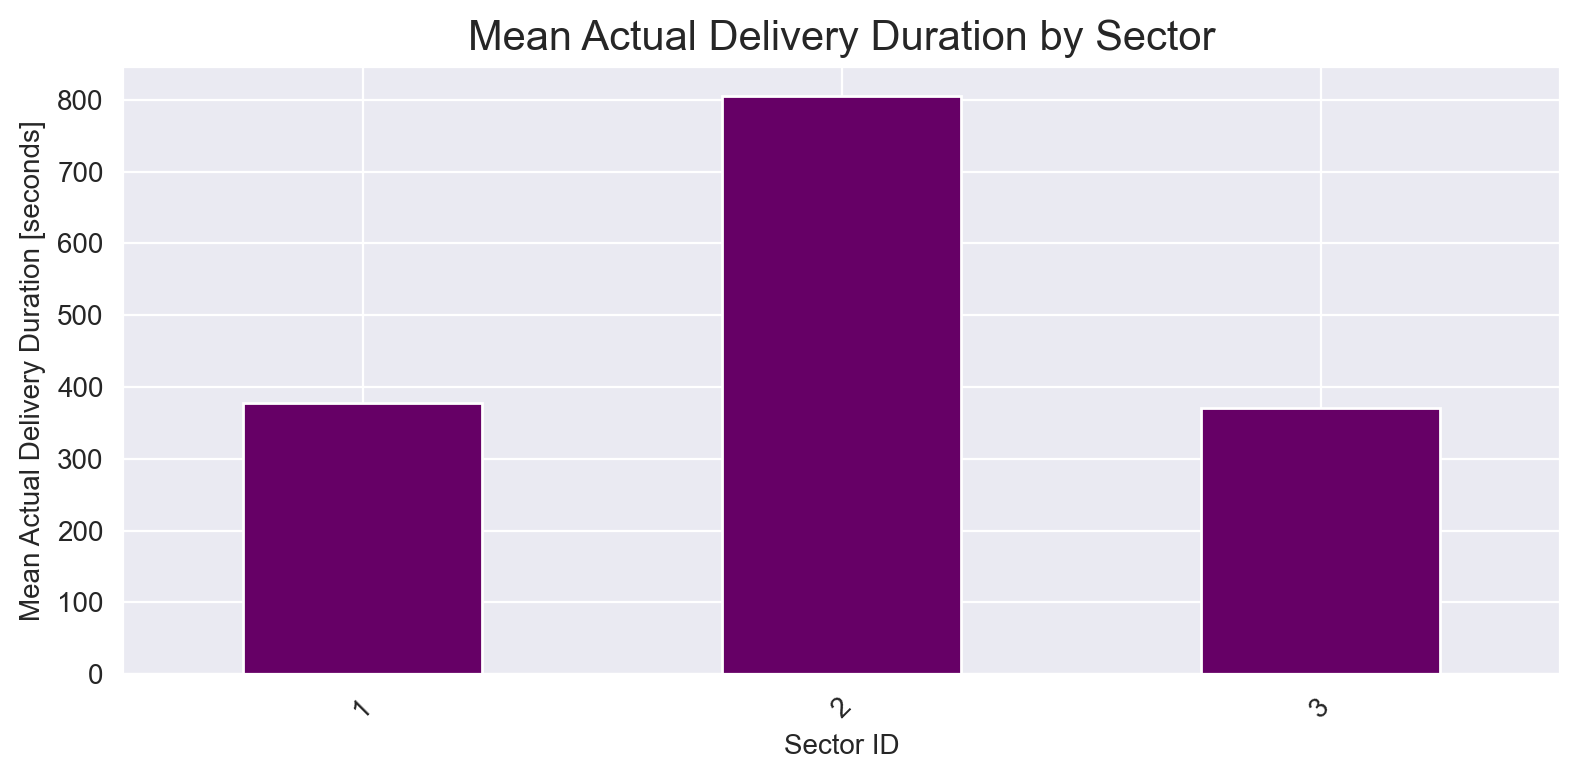

In [1486]:
plt.figure(figsize=(8, 4), dpi=200)
actual_sector_delivery_durations.plot(kind='bar', color='#660066')
plt.title('Mean Actual Delivery Duration by Sector', fontsize=15)
plt.xlabel('Sector ID')
plt.ylabel('Mean Actual Delivery Duration [seconds]')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("charts\\mean_actual_delivery_duration_by_sector"); 

In [1487]:
planned_sector_delivery_durations = delivered_orders.groupby('sector_id')['planned_delivery_duration'].mean()


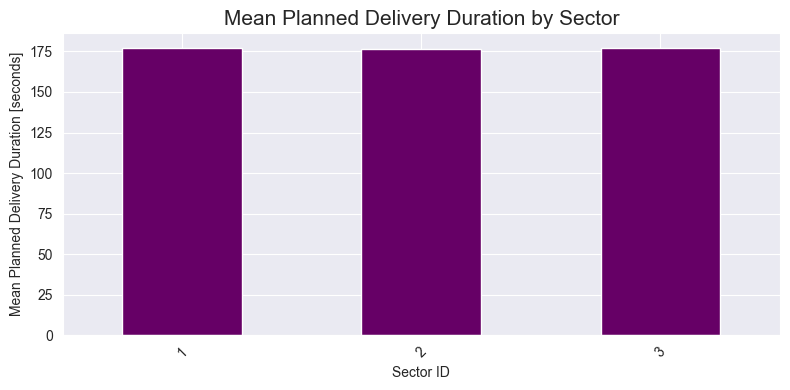

In [1488]:


plt.figure(figsize=(8, 4))
planned_sector_delivery_durations.plot(kind='bar', color='#660066')
plt.title('Mean Planned Delivery Duration by Sector', fontsize=15)
plt.xlabel('Sector ID')
plt.ylabel('Mean Planned Delivery Duration [seconds]')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("charts\\mean_planned_delivery_duration_by_sector");  

In [1489]:
actual_driver_delivery_durations = delivered_orders.groupby('driver_id')['delivery_time_seconds'].mean() # check correlations between driver performance vs actual delivery duration

In [1490]:
actual_driver_delivery_durations

driver_id
1    673.673469
2    404.085106
3    629.931034
4    385.078431
Name: delivery_time_seconds, dtype: float64

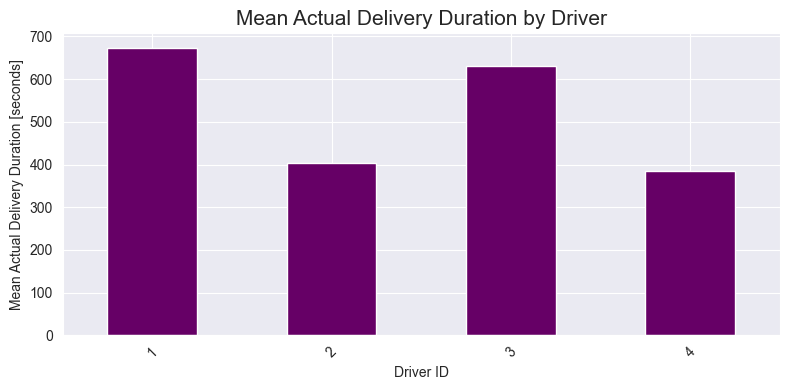

In [1491]:
plt.figure(figsize=(8, 4))
actual_driver_delivery_durations.plot(kind='bar', color='#660066')
plt.title('Mean Actual Delivery Duration by Driver', fontsize=15)
plt.xlabel('Driver ID')
plt.ylabel('Mean Actual Delivery Duration [seconds]')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("charts\\mean_actual_delivery_duration_by_driver");  # calculate mean planned delivery duration in sectors 

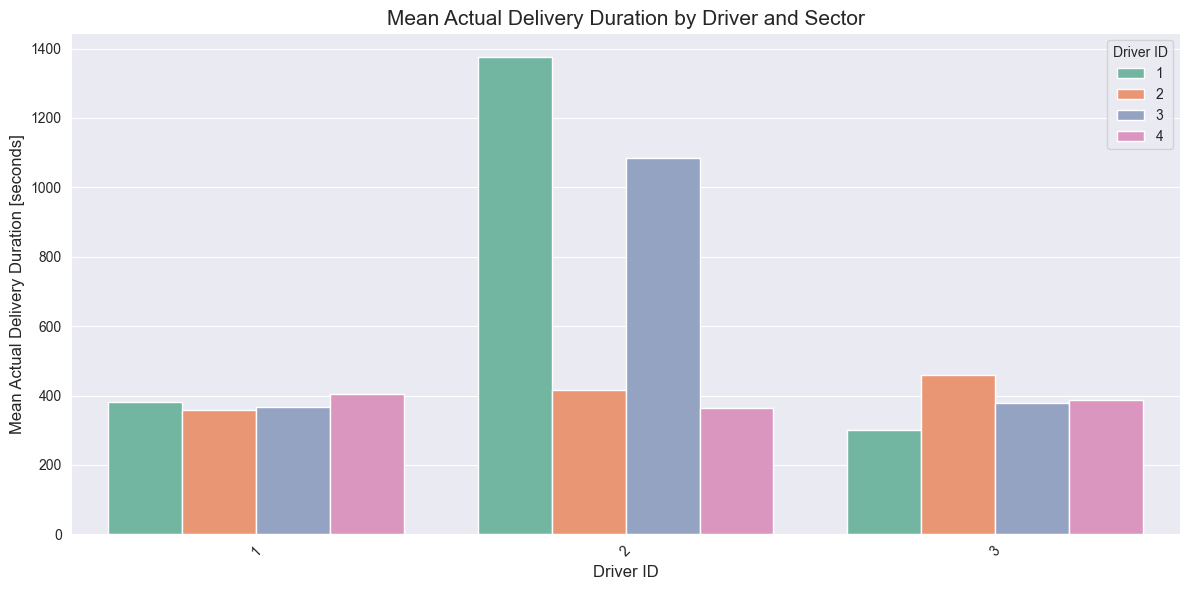

In [1492]:
actual_driver_delivery_durations_sector = delivered_orders.groupby(['driver_id', 'sector_id'])['delivery_time_seconds'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=actual_driver_delivery_durations_sector, x='sector_id', y='delivery_time_seconds', hue='driver_id', palette="Set2")
plt.title('Mean Actual Delivery Duration by Driver and Sector', fontsize=15)
plt.xlabel('Driver ID', fontsize=12)
plt.ylabel('Mean Actual Delivery Duration [seconds]', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Driver ID')
plt.tight_layout()
plt.savefig("charts\\mean_actual_delivery_duration_by_driver_in_sector")

In [1493]:
orders_products = pd.read_csv("DATA\\orders_products.csv")

In [1494]:
all_data_connected_to_delivered_orders = pd.merge(drive_segments, orders_products, on="order_id")

In [1495]:
all_data_connected_to_delivered_orders

,driver_id,segment_type,order_id,segment_start_time,segment_end_time,delivery_time_seconds,delivery_time_rounded_minutes,product_id,quantity
0,2,DRIVE,265,2024-02-07 08:12:03,2024-02-07 08:19:27,444.0,7,15,3
1,2,DRIVE,265,2024-02-07 08:12:03,2024-02-07 08:19:27,444.0,7,52,1
2,2,DRIVE,265,2024-02-07 08:12:03,2024-02-07 08:19:27,444.0,7,79,2
3,3,DRIVE,304,2024-02-19 06:06:11,2024-02-19 06:14:56,525.0,8,22,2
4,3,DRIVE,304,2024-02-19 06:06:11,2024-02-19 06:14:56,525.0,8,29,1
...,...,...,...,...,...,...,...,...,...
221,1,DRIVE,198,2024-02-08 09:15:51,2024-02-08 09:26:57,666.0,11,57,2
222,1,DRIVE,198,2024-02-08 09:15:51,2024-02-08 09:26:57,666.0,11,60,2
223,1,DRIVE,198,2024-02-08 09:15:51,2024-02-08 09:26:57,666.0,11,67,3
224,1,DRIVE,198,2024-02-08 09:15:51,2024-02-08 09:26:57,666.0,11,68,1


In [1496]:
products = pd.read_csv("DATA\\products.csv")

In [1497]:
all_data_connected_to_delivered_orders_and_products = pd.merge(all_data_connected_to_delivered_orders, products, on="product_id")
# merge all available da

In [1498]:
all_data_connected_to_delivered_orders_and_products

,driver_id,segment_type,order_id,segment_start_time,segment_end_time,delivery_time_seconds,delivery_time_rounded_minutes,product_id,quantity,weight
0,2,DRIVE,265,2024-02-07 08:12:03,2024-02-07 08:19:27,444.0,7,15,3,764
1,4,DRIVE,66,2024-02-28 21:15:14,2024-02-28 21:19:51,277.0,4,15,1,764
2,2,DRIVE,265,2024-02-07 08:12:03,2024-02-07 08:19:27,444.0,7,52,1,1306
3,2,DRIVE,265,2024-02-07 08:12:03,2024-02-07 08:19:27,444.0,7,79,2,1599
4,1,DRIVE,322,2024-02-20 07:53:22,2024-02-20 12:03:41,15019.0,250,79,1,1599
...,...,...,...,...,...,...,...,...,...,...
221,2,DRIVE,77,2024-02-14 01:51:03,2024-02-14 01:58:14,431.0,7,70,3,1066
222,2,DRIVE,77,2024-02-14 01:51:03,2024-02-14 01:58:14,431.0,7,94,3,1168
223,1,DRIVE,175,2024-02-12 19:23:45,2024-02-12 19:28:47,302.0,5,17,3,1612
224,2,DRIVE,20,2024-02-25 20:58:36,2024-02-25 21:03:48,312.0,5,1,3,1533


In [1499]:
all_data_connected_to_delivered_orders_and_products['total_weight_delivered'] = all_data_connected_to_delivered_orders_and_products['quantity'] * all_data_connected_to_delivered_orders_and_products['weight']  # calculate ordered product's weight

In [1500]:
all_data_connected_to_delivered_orders_and_products

,driver_id,segment_type,order_id,segment_start_time,segment_end_time,delivery_time_seconds,delivery_time_rounded_minutes,product_id,quantity,weight,total_weight_delivered
0,2,DRIVE,265,2024-02-07 08:12:03,2024-02-07 08:19:27,444.0,7,15,3,764,2292
1,4,DRIVE,66,2024-02-28 21:15:14,2024-02-28 21:19:51,277.0,4,15,1,764,764
2,2,DRIVE,265,2024-02-07 08:12:03,2024-02-07 08:19:27,444.0,7,52,1,1306,1306
3,2,DRIVE,265,2024-02-07 08:12:03,2024-02-07 08:19:27,444.0,7,79,2,1599,3198
4,1,DRIVE,322,2024-02-20 07:53:22,2024-02-20 12:03:41,15019.0,250,79,1,1599,1599
...,...,...,...,...,...,...,...,...,...,...,...
221,2,DRIVE,77,2024-02-14 01:51:03,2024-02-14 01:58:14,431.0,7,70,3,1066,3198
222,2,DRIVE,77,2024-02-14 01:51:03,2024-02-14 01:58:14,431.0,7,94,3,1168,3504
223,1,DRIVE,175,2024-02-12 19:23:45,2024-02-12 19:28:47,302.0,5,17,3,1612,4836
224,2,DRIVE,20,2024-02-25 20:58:36,2024-02-25 21:03:48,312.0,5,1,3,1533,4599


In [1501]:
total_weight_vs_delivery_time = all_data_connected_to_delivered_orders_and_products.groupby('order_id').agg({'total_weight_delivered': 'sum', 'delivery_time_seconds': 'first'}).reset_index()  # sum weights for each order

In [1502]:
total_weight_vs_delivery_time

,order_id,total_weight_delivered,delivery_time_seconds
0,4,10208,684.0
1,10,16861,338.0
2,11,8265,184.0
3,20,8159,312.0
4,27,7387,194.0
...,...,...,...
64,318,6434,506.0
65,319,4866,637.0
66,320,8055,511.0
67,322,14324,15019.0


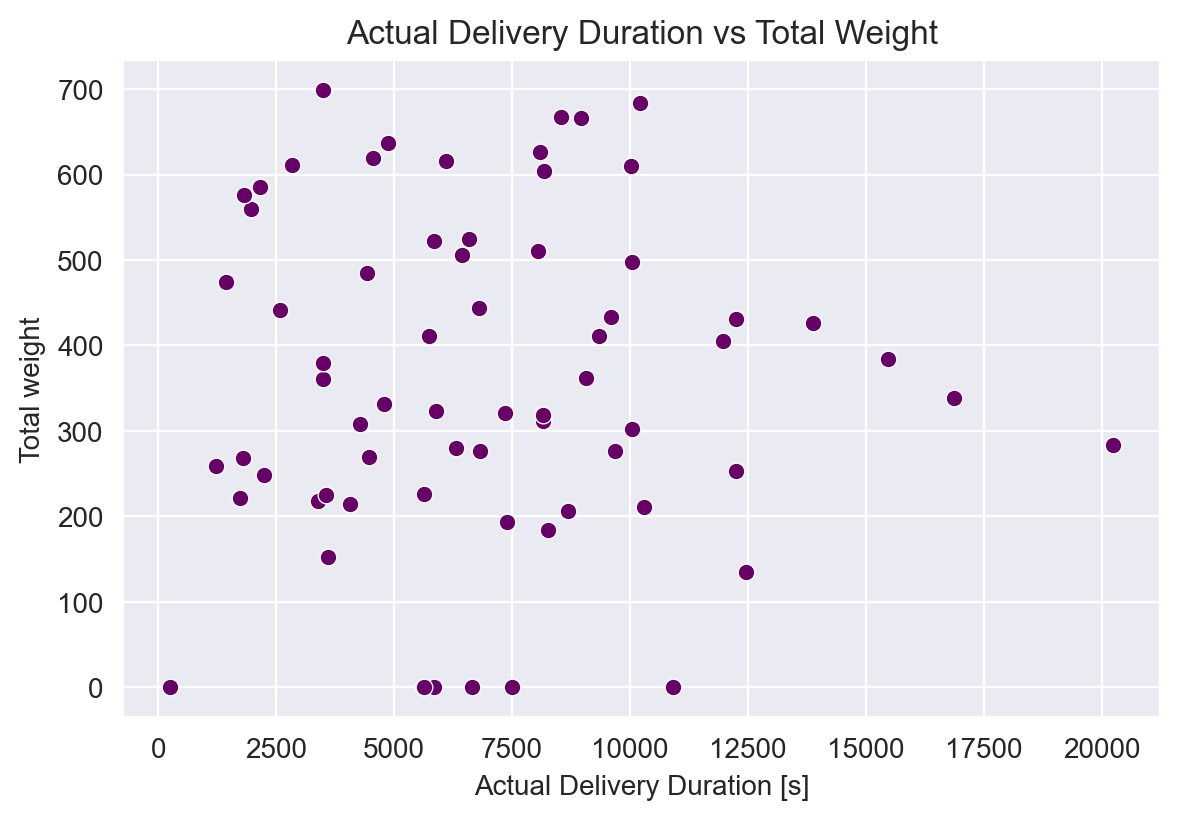

In [1503]:
plt.figure(figsize=(6, 4), dpi=200)
sns.scatterplot(data=total_weight_vs_delivery_time[total_weight_vs_delivery_time["delivery_time_seconds"] < 14000], x="total_weight_delivered", y="delivery_time_seconds", color="#660066")
plt.xlabel("Actual Delivery Duration [s]")
plt.ylabel("Total weight")
plt.tight_layout()
plt.title("Actual Delivery Duration vs Total Weight")
plt.savefig("charts\\actual_delivery_duration_vs_total_weight")
# check correlations between actual delivery time and total order's weight

In [1504]:
delivered_orders['day_of_week'] = drive_segments['segment_end_time'].dt.day_name()

In [1505]:
actual_day_of_the_week_delivery_durations = delivered_orders.groupby(['driver_id', 'sector_id', 'day_of_week'])['delivery_time_seconds'].mean().reset_index()

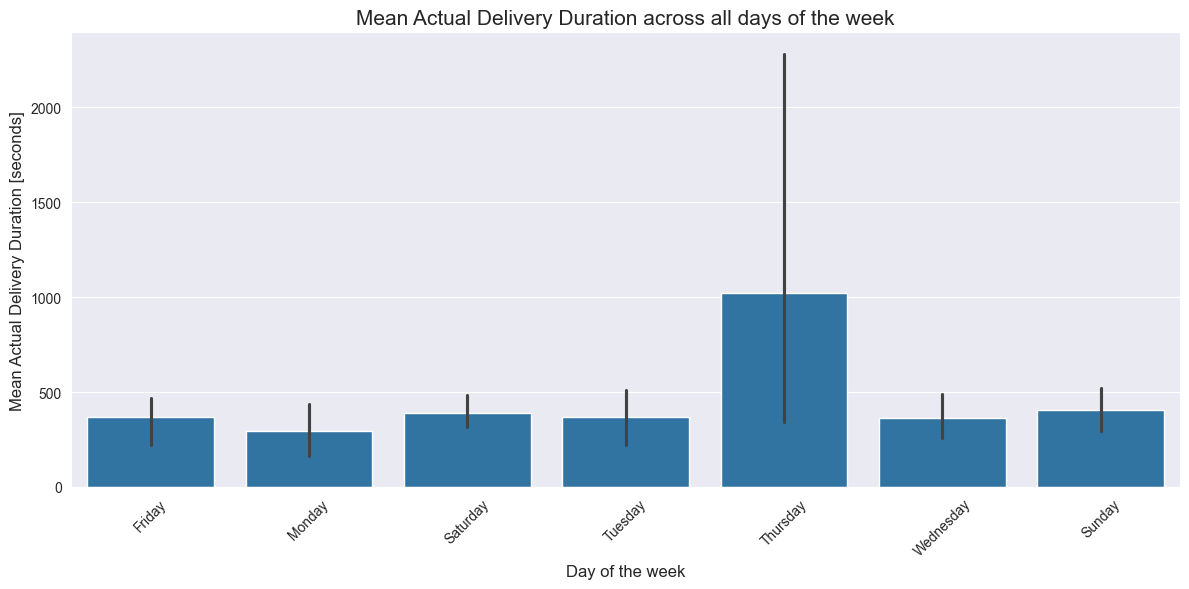

In [1506]:
plt.figure(figsize=(12, 6))
sns.barplot(data=actual_day_of_the_week_delivery_durations, x='day_of_week', y='delivery_time_seconds')
plt.title('Mean Actual Delivery Duration across all days of the week', fontsize=15)
plt.xlabel('Day of the week', fontsize=12)
plt.ylabel('Mean Actual Delivery Duration [seconds]', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("charts\\mean_actual_delivery_duration_week_days")